In [115]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import PIL
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, Layer
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model
from keras import backend as K
from keras.metrics import binary_crossentropy
import seaborn as sns



# Variational Autoencoders
Variational autoencoders are a subtype of autoencoders. In VAEs, instead of mapping your image to a specific vector, you map it to a probability distribution. You typically assume a normal distribution and map the image to its mean and standard deviation. You then sample a vector using the distribution. Part of the loss is the K-L divergence between the standard normal distribution and the learned distribution. This forces a normal distribution. The other part of the loss is just the reconstruction loss.

Loss = reconstruction loss + KL divergence

How to sample the vector and do backprop?
Answer z = meean + sigma * std normal distribution
Note the standard normal distribution is (obviously) not learned. So you don't really have to worry about the sampling during training since only the mean and sigma are trained.

# Load Data

In [113]:
(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

In [5]:
# Reshape data
img_width = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)

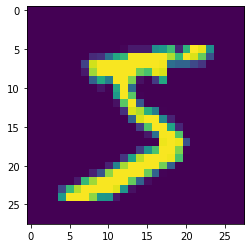

In [17]:
plt.imshow(x_train[0])
plt.show()


# Build Model

## Make the Custom Loss

In [101]:
class VAELoss(Layer):
    def vae_loss(self, x, z_decoded, z_sigma, z_mu):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss compares input and decoded image
        recon_loss = binary_crossentropy(x, z_decoded)

        # KL Divergence compares distribution to normal
        kl_div = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)

        return K.mean(recon_loss + kl_div)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_sigma = inputs[2]
        z_mu = inputs[3]
        loss = self.vae_loss(x, z_decoded, z_sigma, z_mu)
        self.add_loss(loss, inputs=inputs)
        return x

## Make the Model

In [102]:
class VAE(Model):
    def __init__(self, latent_dim, input_shape):
        super(VAE, self).__init__()
        
        # Define encoder
        enc_inputs = Input(shape=input_shape)
        x = Conv2D(32, 3, padding='same', activation='relu')(enc_inputs)
        x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
        x = Conv2D(64, 3, padding='same', activation='relu')(x)
        x = Conv2D(64, 3, padding='same', activation='relu')(x)

        conv_shape = K.int_shape(x)

        x = Flatten()(x)
        x = Dense(32, activation='relu')(x)

        z_mu = Dense(latent_dim, name='latent_mu')(x)
        z_sigma = Dense(latent_dim, name='latent_sigma')(x)
        # Sampling layer
        z = Lambda(self.sample, output_shape=(latent_dim,), name='z')([z_mu, z_sigma])

        self.encoder = Model(enc_inputs, [z_mu, z_sigma, z], name='encoder')

        # Define decoder
        dec_inputs = Input(shape=(latent_dim,))

        # First get to same shape as the convoluted image in the encoder
        x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3])(dec_inputs)
        x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

        # Then apply transposed convolutions to reconstruct the image
        x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
        x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid')(x)

        decode_shape = K.int_shape(x)

        self.decoder = Model(dec_inputs, x, name='decoder')
        
        # Define model for loss calculation
        z_decoded_input = Input(shape=decode_shape[1:], name='z_decoded input')
        z_sigma_input = Input(shape=K.int_shape(z_sigma)[1:], name='z_sigma input')
        z_mu_input = Input(shape=K.int_shape(z_mu)[1:], name='z_mu input')

        loss = VAELoss()([enc_inputs, z_decoded_input, z_sigma_input, z_mu_input])

        self.loss_model = Model([enc_inputs, z_decoded_input, z_sigma_input, z_mu_input], loss, name='loss_model')

    def call(self, x):
        mu, sigma, z = self.encoder(x)
        z_decoded = self.decoder(z)
        loss = self.loss_model([x, z_decoded, sigma, mu])
        return loss

    # Sample a random vector using the learned mean and standard deviation, assuming a normal distribution
    def sample(self, args):
        z_mu, z_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
        return z_mu + K.exp(z_sigma/2) * epsilon

vae = VAE(2, x_train[0].shape)
vae.build((None, x_train.shape[1], x_train.shape[2], x_train.shape[3]))
vae.summary()

Model: "vae_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 2),               494244    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         56385     
                                                                 
 loss_model (Functional)     (None, 28, 28, 1)         0         
                                                                 
Total params: 550,629
Trainable params: 550,629
Non-trainable params: 0
_________________________________________________________________


In [108]:
vae.compile(optimizer='adam', loss=None)
vae.fit(x_train, None, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/10
750/750 [==============================] - 7s 8ms/step - loss: 0.1802 - val_loss: 0.1818
Epoch 2/10
750/750 [==============================] - 6s 8ms/step - loss: 0.1796 - val_loss: 0.1819
Epoch 3/10
750/750 [==============================] - 6s 8ms/step - loss: 0.1794 - val_loss: 0.1812
Epoch 4/10
750/750 [==============================] - 6s 8ms/step - loss: 0.1791 - val_loss: 0.1816
Epoch 5/10
750/750 [==============================] - 6s 8ms/step - loss: 0.1788 - val_loss: 0.1814
Epoch 6/10
750/750 [==============================] - 6s 8ms/step - loss: 0.1786 - val_loss: 0.1816
Epoch 7/10
750/750 [==============================] - 6s 8ms/step - loss: 0.1784 - val_loss: 0.1811
Epoch 8/10
750/750 [==============================] - 6s 8ms/step - loss: 0.1782 - val_loss: 0.1815
Epoch 9/10
750/750 [==============================] - 6s 8ms/step - loss: 0.1779 - val_loss: 0.1809
Epoch 10/10
750/750 [==============================] - 6s 8ms/step - loss: 0.1777 - val_loss: 0.1809

In [66]:
x_train[0].shape

(28, 28, 1)

# Visualizations

In [110]:
mu, sigma, z = vae.encoder(x_test)

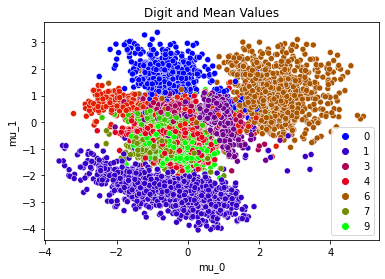

In [130]:
mu_1 = mu[:,0]
mu_2 = mu[:,1]
sns.scatterplot(x=mu_1, y=mu_2, hue=y_test, palette='brg')
plt.title('Digit and Mean Values')
plt.xlabel('mu_0')
plt.ylabel('mu_1')
plt.show()

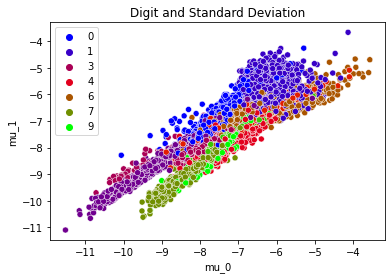

In [133]:
sigma_1 = sigma[:,0]
sigma_2 = sigma[:,1]
sns.scatterplot(x=sigma_1, y=sigma_2, hue=y_test, palette='brg')
plt.title('Digit and Standard Deviation')
plt.xlabel('mu_0')
plt.ylabel('mu_1')
plt.show()